I have the clean data from the previous step that includes: <br>
- DATE: in datetime format <br>
- PRCP: water equivalent (in) or precipitation (if all the snow was melted down to water) <br>
- SNOW: new snow measured in inches <br>
- SNWD: snow depth measured in inches <br>
- TMAX: max temperature observed on that day <br>
- TMIN: min temperature observed on that day <br>
- TOBS: official observed tempterature observed on that day <br>
- MONTH: month separated from Date to make groupby easier <br>
- DAY: day separated from Date to make groupby easier <br>
- PDO: pacific decadal oscillation; data given by the month but interpolated to the day <br>
- AMO: atlantic decadal oscillation; data measure by the month but interpolated to the day <br>

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
import ppscore as pps

In [2]:
import pickle
path="C:\Springboard\Github\Capstone1_alta\intermediate_data"
os.chdir(path)

In [3]:
ALTA = pickle.load(open("alta_snow_clean2.pkl", "rb"))
ALTA.head()

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO
0,1944-11-21,0.00,0.0,20.0,52.0,9.0,20.0,11,21,0.2,0.272
1,1944-11-22,0.00,0.0,19.0,48.0,19.0,29.0,11,22,0.2,0.272
2,1944-11-23,0.00,0.0,19.0,56.0,24.0,40.0,11,23,0.2,0.272
3,1944-11-24,0.82,6.0,25.0,52.0,14.0,16.0,11,24,0.2,0.272
4,1944-11-25,0.06,11.0,36.0,26.0,11.0,14.0,11,25,0.2,0.272


This data looks just like how I left it; now, let's see if I can gather some stats on the different values

In [4]:
ALTA.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO
count,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21200.000000,21808.000000
mean,0.154552,1.501756,39.350956,46.094742,27.220721,36.997859,0.009221,0.003105
std,0.357696,3.661164,41.374939,17.692602,15.550385,18.270581,1.090899,0.216529
min,0.000000,0.000000,0.000000,-8.000000,-26.000000,-18.000000,-3.600000,-0.527000
25%,0.000000,0.000000,0.000000,32.000000,16.000000,23.000000,-0.783903,-0.152215
50%,0.000000,0.000000,26.000000,44.000000,26.000000,34.000000,0.050000,0.010298
75%,0.120000,0.500000,74.000000,62.000000,40.000000,51.000000,0.752903,0.158827
max,5.000000,38.000000,179.000000,113.000000,77.000000,84.000000,3.510000,0.519000


These values look good, but there are a few things that stand out to me: <br>
Snowfall max - 38in in a 24hrs is a lot, but it's very possible at Alta; since I focus on predicting this catagory, I need to leave this in <br>
Tmax - this max value of 113 seems extremely high for the town of Alta. I will need to plot this to see how it looks on a scatter. My instinct says this is a measurement error. <br>
All of the other values seem good.

This does include summertime data, so there will be a lot of 0's for snowfall and snow depth. Even for winter, I expect a lot of days of 0 snowfall with some deep days in there. <br>
Snowfall (our variable of interest) looks like it has an exponential distribution. <br> 
Let's also compute a rolling sum of the snowfall to see if that brings about a better distribution; we will do that for both 14 and 7 days.

In [5]:
ALTA["SNOW7"] = ALTA.rolling(window=7)['SNOW'].sum()
ALTA["SNOW14"] = ALTA.rolling(window=14)['SNOW'].sum()
# a 30-day index would also be good to plot versus PDO and AMO, since those change more long-term
ALTA["SNOW30"] = ALTA.rolling(window=30)['SNOW'].sum()

In [6]:
ALTA.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
count,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21809.000000,21200.000000,21808.000000,2.180300e+04,2.179600e+04,2.178000e+04
mean,0.154552,1.501756,39.350956,46.094742,27.220721,36.997859,0.009221,0.003105,1.051335e+01,2.102880e+01,4.508577e+01
std,0.357696,3.661164,41.374939,17.692602,15.550385,18.270581,1.090899,0.216529,1.425929e+01,2.345198e+01,4.231070e+01
min,0.000000,0.000000,0.000000,-8.000000,-26.000000,-18.000000,-3.600000,-0.527000,-4.440892e-14,-7.105427e-14,-2.016165e-13
25%,0.000000,0.000000,0.000000,32.000000,16.000000,23.000000,-0.783903,-0.152215,-2.037259e-14,-1.265654e-14,2.500000e+00
50%,0.000000,0.000000,26.000000,44.000000,26.000000,34.000000,0.050000,0.010298,4.000000e+00,1.400000e+01,3.920000e+01
75%,0.120000,0.500000,74.000000,62.000000,40.000000,51.000000,0.752903,0.158827,1.700000e+01,3.450000e+01,7.300000e+01
max,5.000000,38.000000,179.000000,113.000000,77.000000,84.000000,3.510000,0.519000,9.900000e+01,1.540000e+02,2.675000e+02


This has me so stoked to see the median of 4 inches for 7-day sum. That includes summer! <br>
Let's separate winter and look at the histograms again.

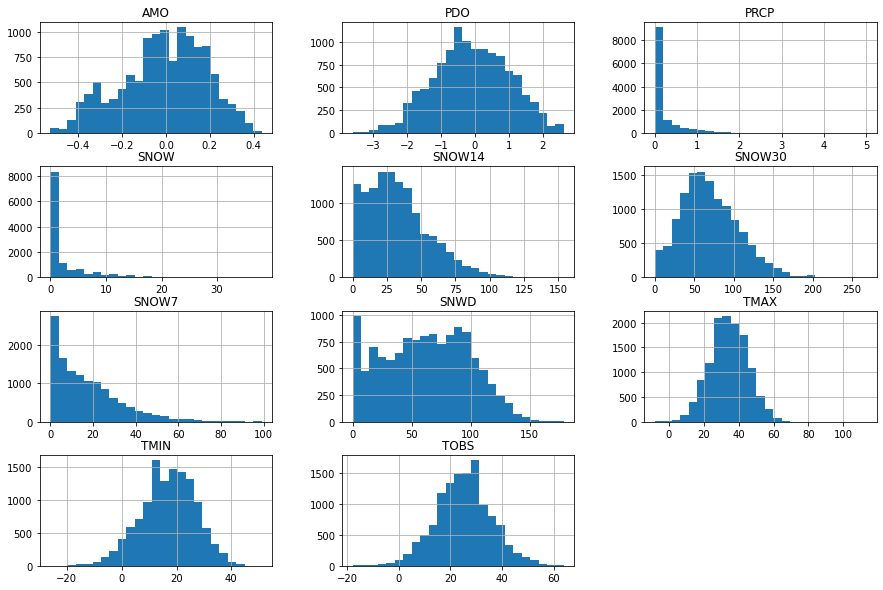

In [7]:
win = ALTA[ALTA.MONTH.isin(['11','12','01','02','03','04'])]
hist = win.hist(bins=25, figsize=(15,10))

The distributions of 7-day, 14-day, and 30-day snowfall look much better than the 1 days totals. I will probably have to take the log of the 7-day snowfall total, but that can wait.

In [8]:
# let's look at the annual snowfall and see if that has changed over time (possible climate change effects)
win_y = win.groupby(win.DATE.dt.year).sum()

In [9]:
# drop the first year and last year, since those are not complete data sets
win_y.drop(labels=[1944, 2020], axis=0, inplace=True)
win_y

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
DATE,,,,,,,,,,,
1945,38.53,354.1,10327.0,5015.342709,2123.611612,3074.956232,-85.825484,37.925645,2503.7,4746.4,9312.0
1946,35.29,383.0,15013.0,6526.000000,3234.000000,4572.000000,-136.416613,15.670242,2829.0,5969.0,13531.0
1947,34.44,437.9,13121.0,6344.229695,3047.754688,4689.208842,67.457304,-12.754878,3189.3,6508.6,13693.0
1948,47.03,565.6,12716.0,5228.877344,2252.524181,3778.036732,-138.570968,-0.229194,3914.2,7647.4,15642.2
1949,39.20,473.5,12500.0,5940.547138,2597.406598,4045.975803,-261.609839,19.100452,3383.5,6699.0,13861.8
...,...,...,...,...,...,...,...,...,...,...,...
2015,24.77,250.5,6692.0,6521.000000,3565.000000,5135.000000,291.814419,6.396427,1810.3,3649.9,6901.2
2016,38.13,352.9,9454.0,6633.000000,3644.000000,5173.000000,334.867903,43.665274,2445.9,4805.8,10441.9
2017,41.05,407.2,11796.0,6811.000000,3879.666667,5376.000000,121.408548,47.662000,2779.6,5397.4,11547.5


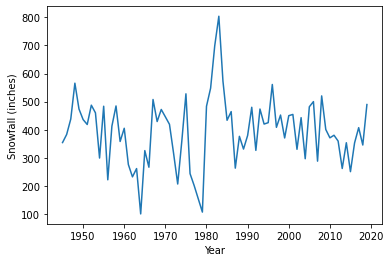

In [10]:
_ = plt.plot(win_y.index, win_y['SNOW'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Snowfall (inches)')

That looks relatively the same; there was a lot more variability from the mid 60's to late 80's, but it appears to be more constants since. Let's take a look at the maximum value in the early 80's.

In [11]:
win_y['SNOW'].max()

804.0

In [12]:
win_y['SNOW'].idxmax()

1983

I want to look at a lot of the other data to see if there are other outliers that could describe what's going on.

In [13]:
win_m = win.groupby(win.DATE.dt.year).mean()
win_m[win_m.index == 1983]

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
DATE,,,,,,,,,,,
1983,0.430663,4.441989,85.171271,31.055249,18.353591,21.906077,1.39026,-0.073773,30.077348,59.441989,119.428177


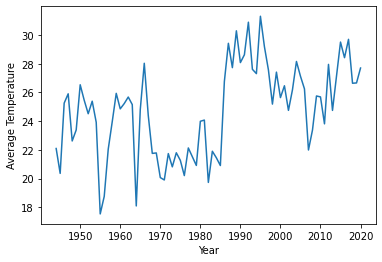

In [14]:
_ = plt.plot(win_m.index, win_m['TOBS'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Average Temperature')

The PDO and AMO from this year don't look that impressive; yes, PDO is high, but not extremely high and AMO is slightly below average, but those are well within normal range.

Before I get into the PDO and AMO, let's look at the pairplot for the variables. And add some variables for the density of snow and the date.

In [15]:
# date variable (not year specific)
win['MD'] = win["MONTH"] + '-' + win['DAY']

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
_ = sns.pairplot(win)

The correlation between precipitation and snowfall is important. If we filter for tempterature, then I bet this would provide a good fit. <br>
There is not much else gained from this pairplot with respect to snowfall, 7-day, 14-day, or 30-day. <br>

In [17]:
# let's look at the correlation matrix and heatmap
corr = win.corr()
corr

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
PRCP,1.000000,0.840813,0.168179,-0.255168,-0.103178,-0.256976,-0.035082,-0.000448,0.354590,0.246336,0.181578
SNOW,0.840813,1.000000,0.187227,-0.347613,-0.187365,-0.353421,-0.010943,-0.004716,0.433582,0.304994,0.218399
SNWD,0.168179,0.187227,1.000000,-0.183909,-0.165589,-0.139777,-0.087967,0.022091,0.358011,0.443249,0.561471
TMAX,-0.255168,-0.347613,-0.183909,1.000000,0.783916,0.816600,0.077689,0.013160,-0.423303,-0.329028,-0.251777
TMIN,-0.103178,-0.187365,-0.165589,0.783916,1.000000,0.798358,0.137765,0.022099,-0.353002,-0.291026,-0.220167
TOBS,-0.256976,-0.353421,-0.139777,0.816600,0.798358,1.000000,0.126963,0.055220,-0.355908,-0.287082,-0.222225
PDO,-0.035082,-0.010943,-0.087967,0.077689,0.137765,0.126963,1.000000,0.012428,-0.021198,-0.030144,-0.042010
AMO,-0.000448,-0.004716,0.022091,0.013160,0.022099,0.055220,0.012428,1.000000,-0.010366,-0.013133,-0.012341
SNOW7,0.354590,0.433582,0.358011,-0.423303,-0.353002,-0.355908,-0.021198,-0.010366,1.000000,0.745279,0.523497
SNOW14,0.246336,0.304994,0.443249,-0.329028,-0.291026,-0.287082,-0.030144,-0.013133,0.745279,1.000000,0.728066


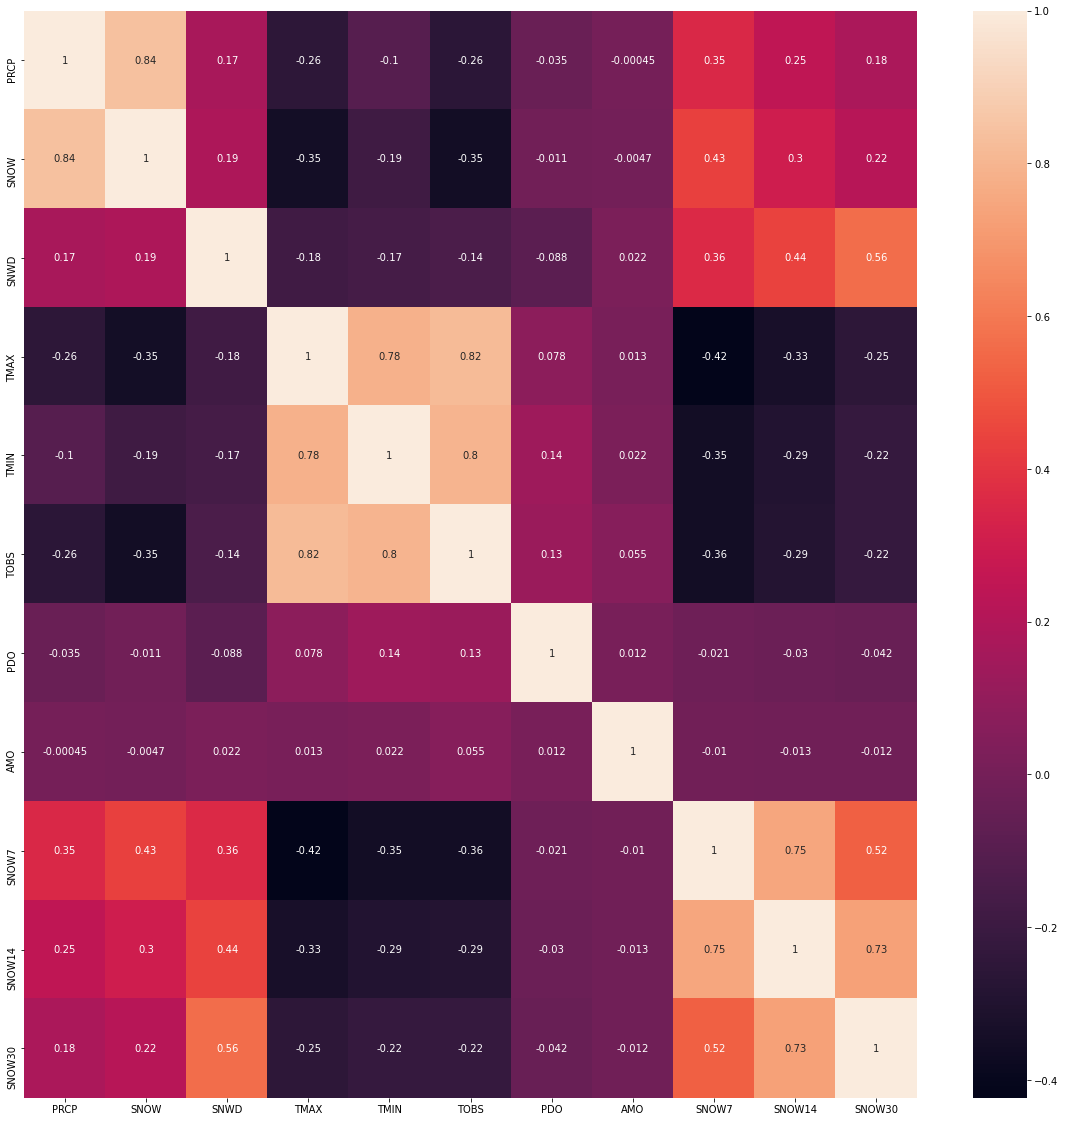

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(corr, annot=True, ax=ax)

Most of the correlations are what we expected: <br>
 - Precipitation is closely correlated wtih snowfall. I will see if we could model this (w/ temperature too) <br>
 - Snowfall is closely correlated with 7-day, 14-day, and 30-day snowfall totals. We could probably drop two of these and just use one of them for modeling purposes. 7-day is most interesting for someone taking a vacation to Alta. <br>
 - All 3 temperatures are closely correlated to each other; for modeling, we probably should drop 2 of these as well. <br>


Other important things to note: 
- PDO and AMO are not correlated strongly to snowfall. These are long-term weather predictors and I was hoping to tease out some values here that made sense
- temperature is correlated loosely to snowfall (I think it may be higher order than linear). Temperature can't be predicted far enough out to mean much, but it's an interesting observations.

In case these relationships are not linear, let's look at the Predictive Power Score

In [19]:
win_pps = pps.matrix(win)

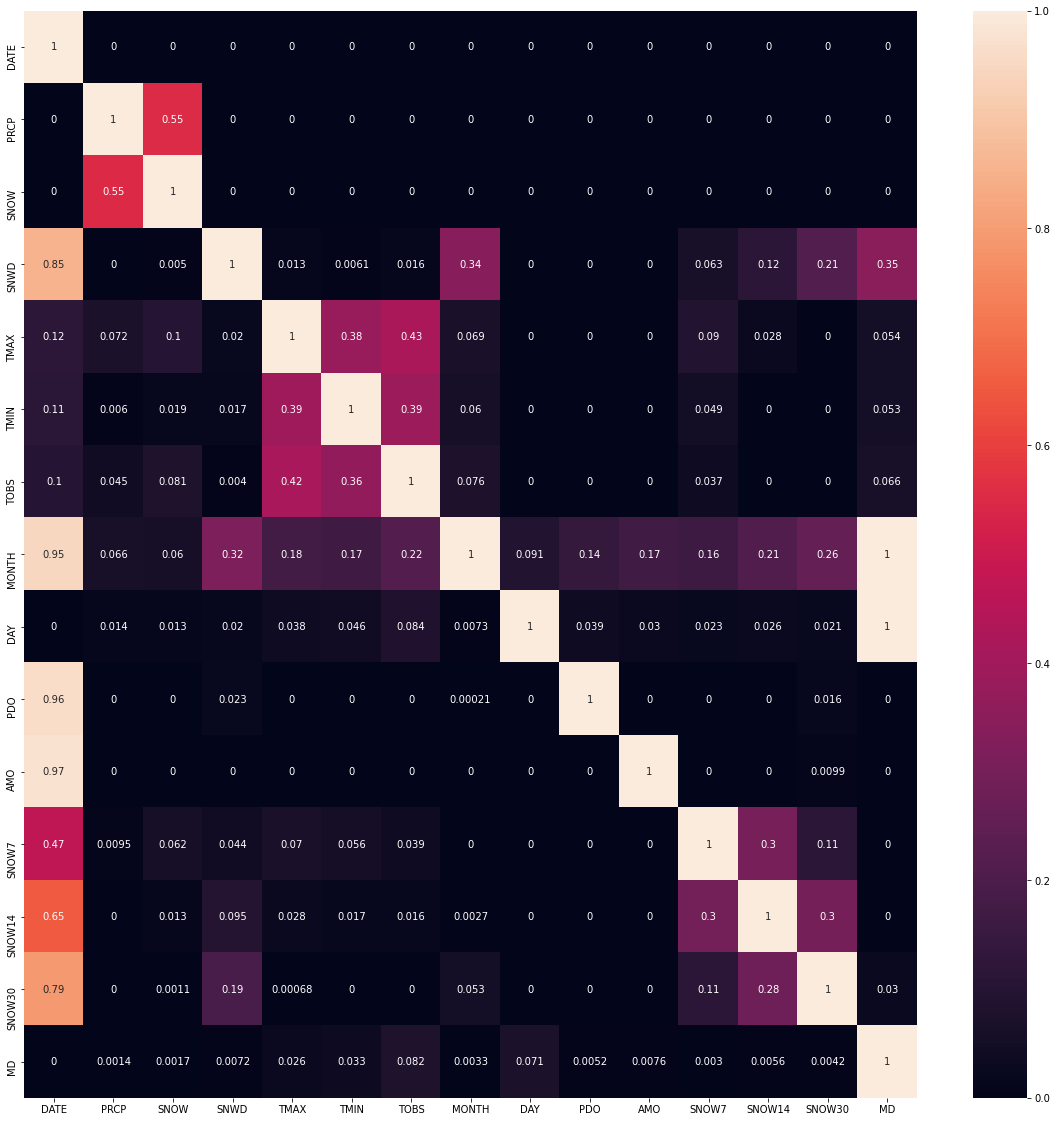

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(win_pps, annot=True, ax=ax)

This was very good to see:
- First thing that is notable is that 7-day snowfall is loosely correlated to date; the longer intervals of snowfall measure and more closely correlated to date (less variability). 1-day snowfall is far too variable and can't be correlated to date. <br>
- It looks like AMO and PDO are very much effected by date, as kind of expected. <br>
- Snow depth is also heavily effected by date. <br>
- Correlation between preciptation and snowfall is not as strong, but adding in temperature maybe able to account for this. <br>
- The three temperature measurements are still related and it makes sense to drop at least 1, if not 2. <br>

I need to move on to PDO and AMO to see if can tease out any effect on snowfall. Since PDO and AMO are long-term metrics that can affect weather, I need to look at them more closely.

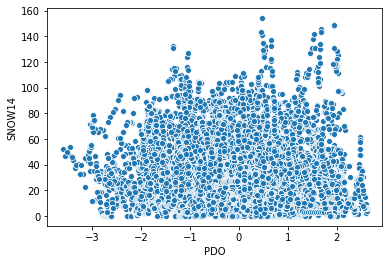

In [21]:
# Let's start with a scatter of snow for 14 days out
sns.scatterplot(win['PDO'], win['SNOW14'])
plt.show()

This doesn't appear to have a clear trend, but we are just scratching the surface. Let's try the 30-day total.

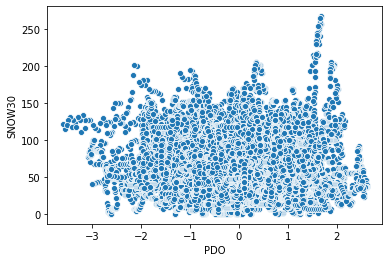

In [22]:
# Let's start with a scatter of snow for 14 days out
sns.scatterplot(win['PDO'], win['SNOW30'])
plt.show()

There appears to be some more large snow months when PDO is between 1.5 and 2. To do that, we'll put the items into buckets so we can take mean and median of PDO values that are similar.

In [23]:
buckets = np.linspace(-4, 3, 14)
win['PDOb'] = pd.cut(win['PDO'], buckets)

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
win_pdo = win.groupby(['PDOb']).median()

In [25]:
win_pdo

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
PDOb,,,,,,,,,,,
"(-4.0, -3.462]",0.00,0.0,103.0,20.5,-4.5,9.000000,-3.527926,0.158661,27.00,49.25,121.00
"(-3.462, -2.923]",0.05,2.0,43.5,28.5,9.0,17.500000,-3.039429,0.326500,23.25,45.75,96.50
"(-2.923, -2.385]",0.00,0.0,83.5,30.5,12.0,20.700000,-2.626774,0.141968,8.00,25.75,59.00
"(-2.385, -1.846]",0.00,0.0,57.0,33.0,16.0,24.000000,-1.976290,-0.061236,13.60,29.75,66.25
"(-1.846, -1.308]",0.00,0.0,69.0,33.0,15.0,22.923077,-1.575333,-0.063000,15.00,31.00,65.70
"(-1.308, -0.769]",0.00,0.0,72.0,34.0,18.0,25.000000,-0.986290,-0.002392,13.00,32.00,70.00
"(-0.769, -0.231]",0.00,0.0,70.0,34.0,17.0,25.000000,-0.472581,0.057214,14.00,30.30,66.20
"(-0.231, 0.308]",0.00,0.0,49.0,34.0,18.0,25.000000,0.042903,0.044400,13.00,28.00,63.00
"(0.308, 0.846]",0.00,0.0,58.0,34.0,19.0,26.000000,0.574516,-0.000194,13.00,29.50,70.00


In [26]:
win_pdo.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.003846,0.153846,64.500000,32.576923,15.423077,23.586391,-0.481199,0.052520,14.296154,31.411538,69.684615
std,0.013868,0.554700,15.836403,4.227125,6.981661,5.510035,2.000338,0.117080,5.331372,7.631299,19.306221
min,0.000000,0.000000,43.500000,20.500000,-4.500000,9.000000,-3.527926,-0.063000,7.500000,21.550000,48.750000
25%,0.000000,0.000000,55.000000,33.000000,15.000000,22.923077,-1.976290,-0.049200,13.000000,28.000000,61.000000
50%,0.000000,0.000000,58.000000,34.000000,18.000000,25.000000,-0.472581,0.014984,13.000000,29.500000,66.200000
75%,0.000000,0.000000,70.000000,34.000000,19.000000,26.000000,1.110323,0.141968,14.000000,31.000000,70.000000
max,0.050000,2.000000,103.000000,37.000000,22.000000,31.500000,2.505000,0.326500,27.000000,49.250000,121.000000


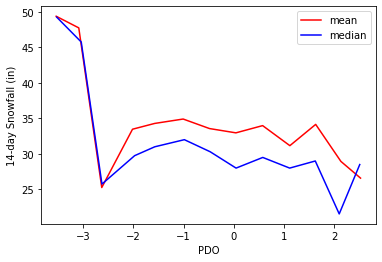

In [27]:
# let's plot that 14-day snowfall for both the median and mean
win_pdom = win.groupby(['PDOb']).mean()
plt.plot(win_pdom['PDO'], win_pdom['SNOW14'], color='red', label='mean')
plt.plot(win_pdo['PDO'], win_pdo['SNOW14'], color='blue', label='median')
plt.xlabel('PDO')
plt.ylabel('14-day Snowfall (in)')
plt.legend()
plt.show()

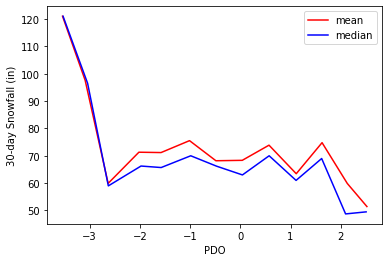

In [28]:
# PDO is a metric that is measured every 30 days, so I wonder if the 30-day looks a little different
plt.plot(win_pdom['PDO'], win_pdom['SNOW30'], color='red', label='mean')
plt.plot(win_pdo['PDO'], win_pdo['SNOW30'], color='blue', label='median')
plt.xlabel('PDO')
plt.ylabel('30-day Snowfall (in)')
plt.legend()
plt.show()

The snowfall looks fairly consistent with PDO, except for when PDO gets strongly negative. This may just be a couple of outliers here, but I would like to find out.

In [29]:
win[win['PDO'] < -2.9]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,MD,PDOb
1134,1949-02-02,0.12,2.5,93.0,20.0,-1.000000,1.000000,02,02,-2.933226,0.156065,12.5,67.5,116.5,02-02,"(-3.462, -2.923]"
1135,1949-02-03,0.15,4.0,95.0,11.0,-1.000000,8.000000,02,03,-2.984516,0.156290,13.5,65.5,120.5,02-03,"(-3.462, -2.923]"
1136,1949-02-04,0.71,6.0,96.0,14.0,0.000000,10.000000,02,04,-3.035806,0.156516,19.5,71.5,126.5,02-04,"(-3.462, -2.923]"
1137,1949-02-05,0.00,0.0,96.0,13.0,-3.000000,-3.000000,02,05,-3.087097,0.156742,19.5,42.5,126.5,02-05,"(-3.462, -2.923]"
1138,1949-02-06,0.00,0.0,94.0,16.0,-11.000000,14.000000,02,06,-3.138387,0.156968,14.5,22.5,126.5,02-06,"(-3.462, -2.923]"
1139,1949-02-07,0.88,10.0,100.0,18.0,2.000000,2.000000,02,07,-3.189677,0.157194,22.5,32.5,134.5,02-07,"(-3.462, -2.923]"
1140,1949-02-08,0.00,0.0,100.0,7.0,-1.000000,4.000000,02,08,-3.240968,0.157419,22.5,32.5,126.5,02-08,"(-3.462, -2.923]"
1141,1949-02-09,0.53,8.0,102.0,16.0,3.000000,14.000000,02,09,-3.292258,0.157645,28.0,40.5,130.5,02-09,"(-3.462, -2.923]"
1142,1949-02-10,0.00,0.0,99.0,30.0,8.000000,29.000000,02,10,-3.343548,0.157871,24.0,37.5,123.5,02-10,"(-3.462, -2.923]"
1143,1949-02-11,0.89,6.0,100.0,29.0,20.000000,21.000000,02,11,-3.394839,0.158097,24.0,43.5,127.5,02-11,"(-3.462, -2.923]"


There were only 3 times the PDO went below 2.9; both the 30-day and 14-day snowfalls went well above normal during those times (at least those times that occurred after November 15th). The PDO hasn't gone that far negative since 1955.

Now, to look at AMO

Higher values appear to be clustered more around and just below 0. Let's see if we can group these together to look for trends in the median or mean.

In [30]:
buckets = np.linspace(-0.55, 0.5, 20)
win['AMOb'] = pd.cut(win['AMO'], buckets)

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
win_amo = win.groupby(['AMOb']).median()
win_amo

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
AMOb,,,,,,,,,,,
"(-0.55, -0.495]",0.0,0.3,117.5,40.00,17.500000,24.500000,-0.575161,-0.509290,23.00,48.00,100.85
"(-0.495, -0.439]",0.0,0.0,105.0,35.00,16.000000,22.000000,-1.098103,-0.462034,16.85,24.00,57.00
"(-0.439, -0.384]",0.0,0.0,20.0,38.00,20.000000,25.000000,0.039000,-0.403839,7.50,19.20,45.50
"(-0.384, -0.329]",0.0,0.0,49.0,33.00,16.000000,23.000000,-0.110833,-0.349283,12.80,31.25,67.90
"(-0.329, -0.274]",0.0,0.0,67.0,31.00,16.000000,23.000000,0.612500,-0.303933,17.10,36.70,78.20
"(-0.274, -0.218]",0.0,0.0,55.0,34.00,18.000000,26.000000,-0.135667,-0.242161,15.00,29.00,67.10
"(-0.218, -0.163]",0.0,0.0,67.0,34.00,17.000000,25.000000,-0.294500,-0.187984,13.00,28.75,71.25
"(-0.163, -0.108]",0.0,0.0,64.0,36.00,19.000000,27.000000,-0.045806,-0.134830,13.00,33.50,65.50
"(-0.108, -0.0526]",0.0,0.0,66.0,34.00,18.000000,25.000000,0.196452,-0.078733,13.00,30.00,67.00


In [32]:
# let's do the same for the average
win_amo_avg = win.groupby(['AMOb']).mean()

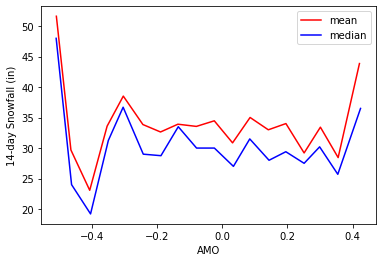

In [33]:
# let's plot the 14-day snowfall for the median and mean
plt.plot(win_amo_avg['AMO'], win_amo_avg['SNOW14'], color='red', label='mean')
plt.plot(win_amo['AMO'], win_amo['SNOW14'], color='blue', label='median')
plt.xlabel('AMO')
plt.ylabel('14-day Snowfall (in)')
plt.legend()
plt.show()

Very interesting that the snowfall also shows up at the extremes. Let's look at the 30-day total too.

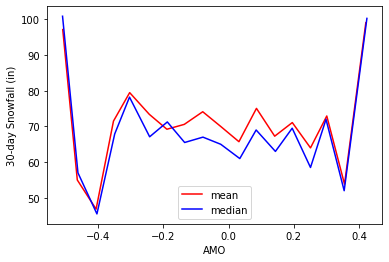

In [34]:
# let's plot the 14-day snowfall for the median and mean
plt.plot(win_amo_avg['AMO'], win_amo_avg['SNOW30'], color='red', label='mean')
plt.plot(win_amo['AMO'], win_amo['SNOW30'], color='blue', label='median')
plt.xlabel('AMO')
plt.ylabel('30-day Snowfall (in)')
plt.legend()
plt.show()

similar effect. Let's see how many points are that far to the extremes.

In [35]:
win[win['AMO'] < -0.484]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,MD,PDOb,AMOb
6109,1974-04-05,0.00,0.0,106.0,31.0,8.0,19.000000,04,05,-0.642581,-0.487645,4.380000e+01,56.8,67.8,04-05,"(-0.769, -0.231]","(-0.495, -0.439]"
6110,1974-04-06,0.13,1.1,106.0,50.0,19.0,26.000000,04,06,-0.630323,-0.491581,4.390000e+01,53.9,68.9,04-06,"(-0.769, -0.231]","(-0.495, -0.439]"
6111,1974-04-07,0.43,5.1,110.0,31.0,18.0,21.000000,04,07,-0.618065,-0.495516,4.120000e+01,59.0,74.0,04-07,"(-0.769, -0.231]","(-0.55, -0.495]"
6112,1974-04-08,0.00,0.0,108.0,43.0,17.0,24.000000,04,08,-0.605806,-0.499452,4.120000e+01,59.0,74.0,04-08,"(-0.769, -0.231]","(-0.55, -0.495]"
6113,1974-04-09,0.00,0.0,106.0,52.0,24.0,38.000000,04,09,-0.593548,-0.503387,2.660000e+01,59.0,74.0,04-09,"(-0.769, -0.231]","(-0.55, -0.495]"
6114,1974-04-10,1.73,15.7,120.0,44.0,15.0,17.000000,04,10,-0.581290,-0.507323,2.780000e+01,67.7,85.7,04-10,"(-0.769, -0.231]","(-0.55, -0.495]"
6115,1974-04-11,1.75,13.0,130.0,28.0,10.0,13.000000,04,11,-0.569032,-0.511258,3.490000e+01,80.7,98.7,04-11,"(-0.769, -0.231]","(-0.55, -0.495]"
6116,1974-04-12,0.84,7.9,134.0,31.0,13.0,21.000000,04,12,-0.556774,-0.515194,4.280000e+01,86.6,106.6,04-12,"(-0.769, -0.231]","(-0.55, -0.495]"
6117,1974-04-13,1.34,11.8,143.0,21.0,11.0,16.000000,04,13,-0.544516,-0.519129,5.350000e+01,97.4,118.4,04-13,"(-0.769, -0.231]","(-0.55, -0.495]"
6118,1974-04-14,0.00,0.0,140.0,31.0,14.0,14.000000,04,14,-0.532258,-0.523065,4.840000e+01,89.6,117.4,04-14,"(-0.769, -0.231]","(-0.55, -0.495]"


Looks like it was only that far negative in April of '74 and March of '76. Let's see the high side too.

In [36]:
win[win['AMO'] > 0.384]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,MD,PDOb,AMOb
2524,1955-11-15,0.00,6.0,34.0,15.00,-6.00,-4.000000,11,15,-3.080000,0.385000,4.300000e+01,47.5,76.5,11-15,"(-3.462, -2.923]","(0.334, 0.389]"
18206,2010-04-08,0.00,0.0,105.0,38.00,13.00,38.000000,04,08,0.700667,0.386800,6.200000e+01,83.5,94.5,04-08,"(0.308, 0.846]","(0.334, 0.389]"
18207,2010-04-09,0.00,0.0,101.0,38.00,13.00,29.000000,04,09,0.712000,0.391400,5.400000e+01,83.0,94.5,04-09,"(0.308, 0.846]","(0.389, 0.445]"
18208,2010-04-10,0.00,0.0,92.0,45.00,18.00,42.000000,04,10,0.723333,0.396000,5.000000e+01,76.0,92.5,04-10,"(0.308, 0.846]","(0.389, 0.445]"
18209,2010-04-11,0.00,0.0,91.0,49.00,38.00,46.000000,04,11,0.734667,0.400600,4.200000e+01,76.0,88.5,04-11,"(0.308, 0.846]","(0.389, 0.445]"
18210,2010-04-12,0.00,0.0,91.0,46.00,29.00,29.000000,04,12,0.746000,0.405200,3.500000e+01,76.0,88.5,04-12,"(0.308, 0.846]","(0.389, 0.445]"
18211,2010-04-13,1.24,12.0,106.0,30.00,22.00,28.000000,04,13,0.757333,0.409800,1.500000e+01,88.0,100.5,04-13,"(0.308, 0.846]","(0.389, 0.445]"
18212,2010-04-14,0.00,0.0,94.0,44.00,16.00,42.000000,04,14,0.768667,0.414400,1.200000e+01,88.0,100.5,04-14,"(0.308, 0.846]","(0.389, 0.445]"
18213,2010-04-15,0.00,0.0,87.0,55.00,9.00,51.000000,04,15,0.780000,0.419000,1.200000e+01,74.0,100.5,04-15,"(0.308, 0.846]","(0.389, 0.445]"
18214,2010-04-16,0.00,0.0,83.0,56.00,36.00,44.000000,04,16,0.774667,0.420133,1.200000e+01,66.0,100.5,04-16,"(0.308, 0.846]","(0.389, 0.445]"


Just 1 day in 1955 has an AMO that high The rest of the data points are from April of 2010. <br>
Both the high and low values have strong snowfall, but they are far out on the extremes with few data points to back that up. 

There maybe some relationship that could eventually be teased out of these PMO and AMO variables, but it maybe slight at best and only obvious after a lot more investigation. I will hault on looking into these variables more. 

Let's investigate that relationship between precipitation and snowfall that we saw had a strong linear correlation

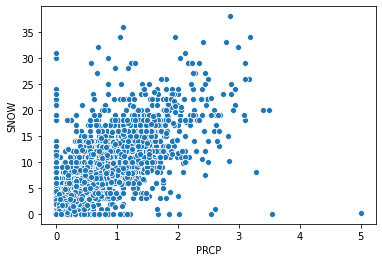

In [37]:
sns.scatterplot(x=win['PRCP'], y=win['SNOW'])

Looks like a good linear relationship that generally holds. There are a few outliers that need to be dealt with, but otherwise this relationship looks really linear. The slope of that line is basically the average density of the snow: how much water is contained in the snow OR moreso, for a given amount of water precipitation, how much snow should be expected. To investigate the variance in density that we see around that general slope of the line, I want to look at inverse density of the snow.

In [38]:
# filter first for actual accumulation of precipitation (that must be measurement error)
wins = win[win['PRCP'] > 0.5]

In [39]:
wins['DEN'] = wins['SNOW']/wins['PRCP']

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


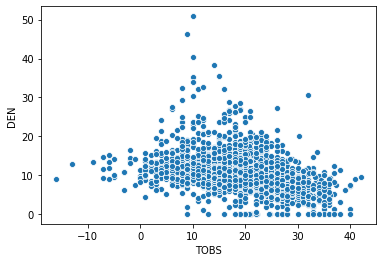

In [40]:
_ = sns.scatterplot(x=wins['TOBS'], y=wins['DEN'])

This kind of looks like a log relationship with some outliers that mess everything up. I will investigate these outliers in more depth later.

Just for fun, let's see if anything happens to the PPS with this new variable.

In [41]:
wins_pps = pps.matrix(wins)

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test part

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test part

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test part

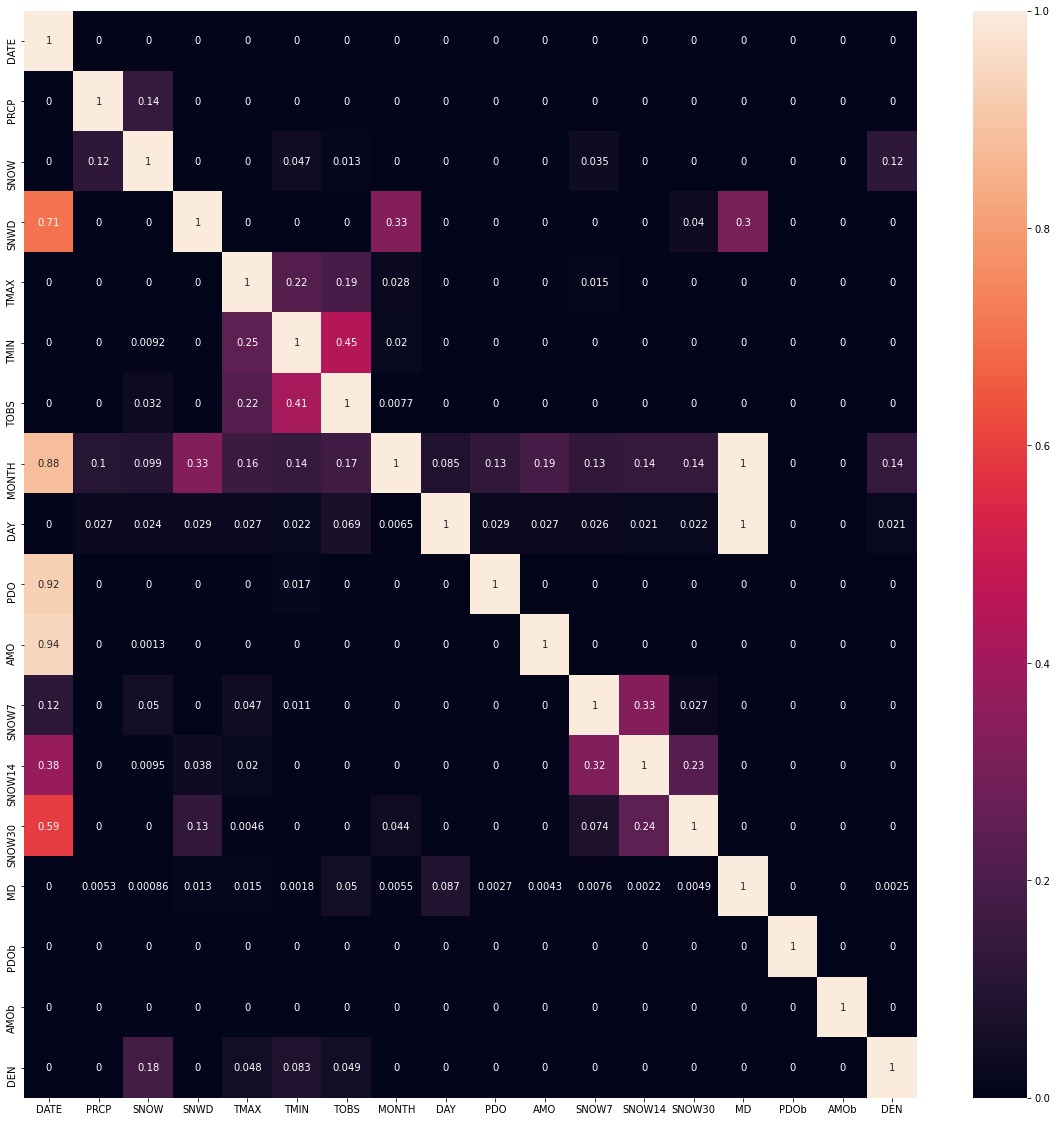

In [42]:
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(wins_pps, annot=True, ax=ax)

The correlation between Density and any of the temperatures is not that strong after all.

That concludes the exploratory data analysis for now.

In [43]:
win_md = win.groupby(['MD']).median()

In [44]:
# let's slice the off April 15th to November 15th
win_md_top = win_md.truncate(before='11-15')

In [45]:
win_md_bottom = win_md.truncate(after='04-15')

In [46]:
win_md_top = win_md_top.append(win_md_bottom)

In [47]:
# now, to do the same for mean
win_mda = win.groupby(['MD']).mean()
win_mda_top = win_mda.truncate(before='11-15')
win_mda_bottom = win_mda.truncate(after='04-15')
win_mda_top = win_mda_top.append(win_mda_bottom)

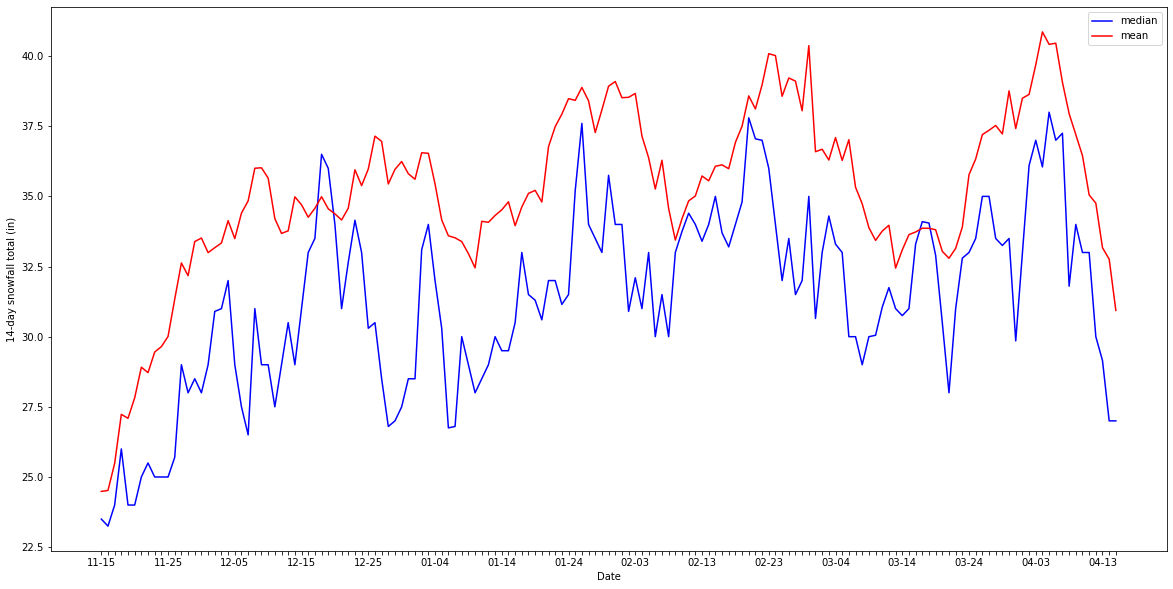

In [48]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
plt.plot(win_md_top.index, win_md_top['SNOW14'], color='blue', label='median')
plt.plot(win_mda_top.index, win_mda_top['SNOW14'], color='red', label='mean')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.ylabel("14-day snowfall total (in)")
plt.xlabel("Date")
plt.legend()
plt.show()

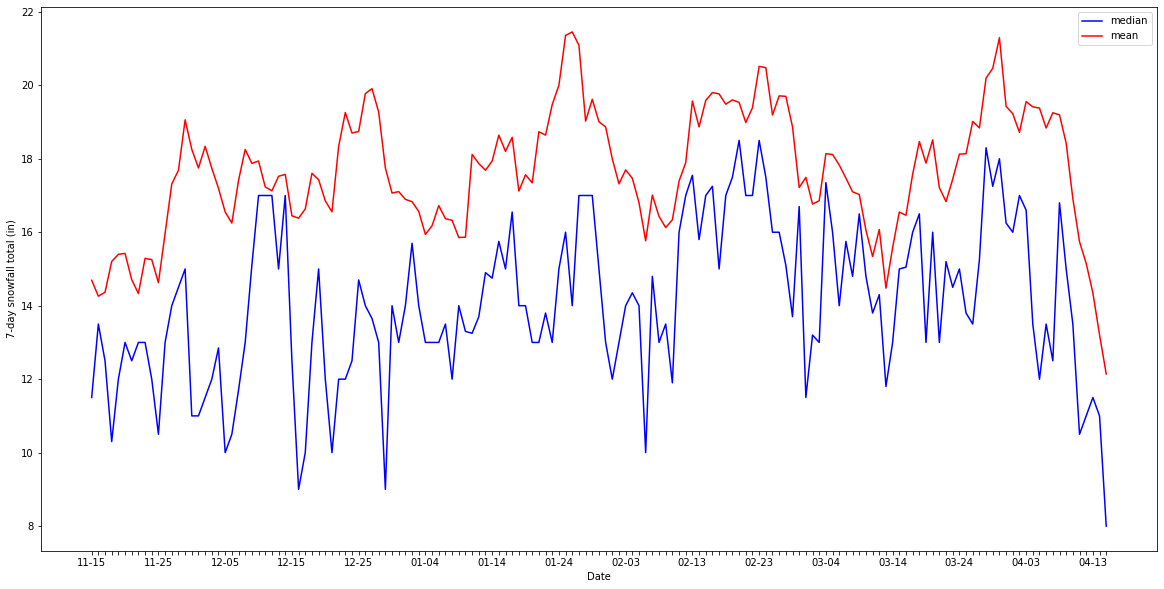

In [49]:
# let's see the 7-day plot
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
plt.plot(win_md_top.index, win_md_top['SNOW7'], color='blue', label='median')
plt.plot(win_mda_top.index, win_mda_top['SNOW7'], color='red', label='mean')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.ylabel("7-day snowfall total (in)")
plt.xlabel("Date")
plt.legend()
plt.show()
#plt.savefig('7day_m.jpg')

These were great to visualize. I definitely see times of the year that I would prefer to ski: late January, mid to late February, and late March into early April. <br>
Maybe more important than getting a lot of snow on a 7-day stay, is at least getting some decent snow. As a skier, I would prefer to increase my chance of not getting skunked rather than increase my chances of a big dump. Let's see how that looks over the years.

In [50]:
# let's say that more than 10 inches is a good week at Alta; it's not great, but decent
win_mdc7 = win[win['SNOW7']>10].groupby('MD').count()
# since it's a count, let's drop a lot all but MD and SNOW
# win_mdc7 = win_mdc7.drop()
win_years = win.groupby('MD').count()
win_mdc7['PERC'] = (win_mdc7['SNOW']/win_years['SNOW'])*100

In [51]:
# reorganizes the dates in the correct order
win_mdc7_top = win_mdc7.truncate(before='11-15')
win_mdc7_bottom = win_mdc7.truncate(after='04-15')
win_mdc7_top = win_mdc7_top.append(win_mdc7_bottom)

Text(0.5, 0, 'Date')

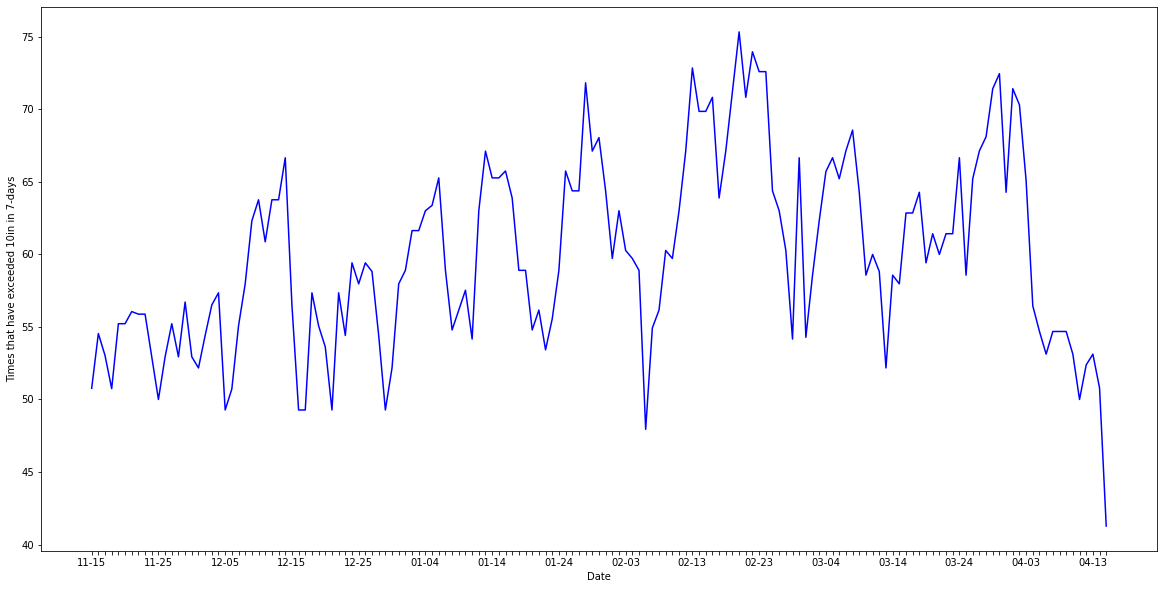

In [52]:
# let's see the 7-day plot
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
plt.plot(win_mdc7_top.index, win_mdc7_top['PERC'], color='blue')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.ylabel("Times that have exceeded 10in in 7-days")
plt.xlabel("Date")

This is an excellent look at when to expect the most consistent snow at Alta. It looks the best dates have 10-inches or more of snow in more than 70% of the years. Wonder what happens if we look for a great week that has 20+ inches of snow

In [53]:
# let's say that more than 20+ inches is a great week at Alta
win_mdc20 = win[win['SNOW7']>=20].groupby('MD').count()
# since it's a count, let's drop a lot all but MD and SNOW
# win_mdc7 = win_mdc7.drop()
win_mdc20['PERC'] = (win_mdc20['SNOW']/win_years['SNOW'])*100

In [54]:
# reorganizes the dates in the correct order
win_mdc20_top = win_mdc20.truncate(before='11-15')
win_mdc20_bottom = win_mdc20.truncate(after='04-15')
win_mdc20_top = win_mdc20_top.append(win_mdc20_bottom)

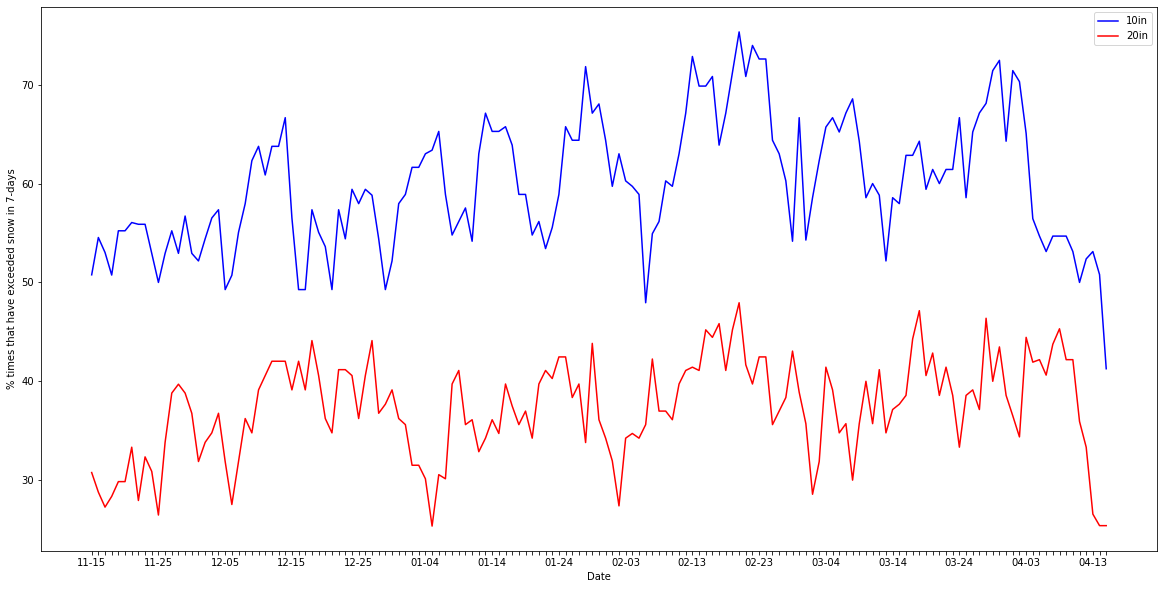

In [55]:
# let's see the 20-inch plot
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
plt.plot(win_mdc7_top.index, win_mdc7_top['PERC'], color='blue', label='10in')
plt.plot(win_mdc20_top.index, win_mdc20_top['PERC'], color='red', label='20in')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.ylabel("% times that have exceeded snow in 7-days")
plt.xlabel("Date")
plt.legend()
plt.show()
#plt.savefig('7day_sum.jpg')

That trends look similar to the previous graph, although the "really good" weeks are spread a little more equally throughout the year. 

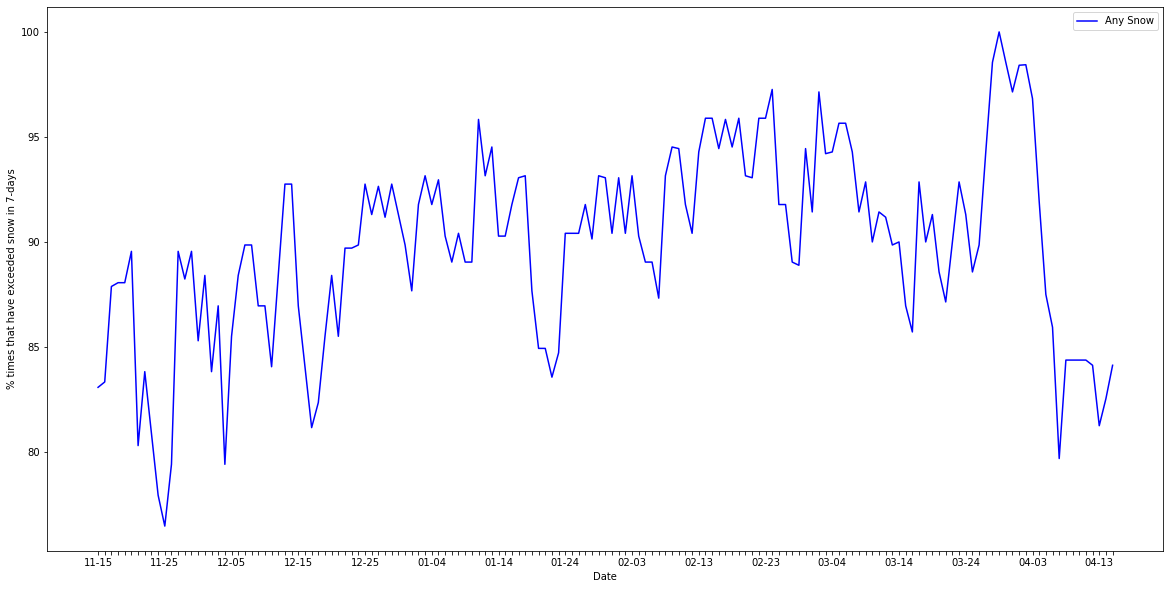

In [107]:
# Let's see how many times you would get skunked at Alta
win_mdc0 = win[win['SNOW7']>0].groupby('MD').count()
win_mdc0['PERC'] = (win_mdc0['SNOW']/win_years['SNOW'])*100
# puts the dates in the correct order
win_mdc0_top = win_mdc0.truncate(before='11-15')
win_mdc0_bottom = win_mdc0.truncate(after='04-15')
win_mdc0_top = win_mdc0_top.append(win_mdc0_bottom)
# Let's see that plot
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
plt.plot(win_mdc0_top.index, win_mdc0_top['PERC'], color='blue', label='Any Snow')
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.ylabel("% times that have exceeded snow in 7-days")
plt.xlabel("Date")
plt.legend()
plt.show()
#plt.savefig('7day_any.jpg')

In [106]:
# let's see when and what that max percentage is
win_mdc0
print(win_mdc0_top['PERC'].max(), win_mdc0_top['PERC'].idxmax())

100.0 03-29


Literally, every year since 1946, it has snowed at least a measureable amount the week beginning March 29th. Wow!

In [109]:
win[win['MD']=='03-29']['SNOW7'].all()

True

In [124]:
print(win[win.index == win[win['MD']=='03-29']['SNOW7'].idxmin()])

           DATE  PRCP  SNOW  SNWD  TMAX  TMIN  TOBS MONTH DAY       PDO  \
4083 1966-03-29   0.0   0.0   7.0  51.0  32.0  47.0    03  29 -0.680323   

           AMO  SNOW7  SNOW14  SNOW30     MD              PDOb  \
4083  0.010935    0.5     2.2     7.8  03-29  (-0.769, -0.231]   

                   AMOb  YEAR  
4083  (0.00263, 0.0579]  1966  


In [125]:
print(win[win.index == win[win['MD']=='03-29']['SNOW7'].idxmax()])

           DATE  PRCP  SNOW   SNWD  TMAX  TMIN  TOBS MONTH DAY       PDO  \
8579 1983-03-29   0.0   0.0  134.0  28.0  12.0  16.0    03  29  2.001613   

           AMO  SNOW7  SNOW14  SNOW30     MD            PDOb             AMOb  \
8579  0.074065   85.0   117.0   169.0  03-29  (1.923, 2.462]  (0.0579, 0.113]   

      YEAR  
8579  1983  


In [130]:
# percent chance of more than 10 inches
win_mdc7_top.loc['03-29','PERC']

71.42857142857143

In [129]:
# percent chance of more than 20 inches
win_mdc20_top.loc['03-29','PERC']

40.0

We will focus on 7-day snowfall total, so I need to check the distribution of these values: are they normally distributed?

In [56]:
from scipy.stats import normaltest
# null hypothesis is that SNOW7 is normally distributed
z, p = normaltest(win['SNOW7'], nan_policy='omit')
p

0.0

C:\Users\sjrek\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\sjrek\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


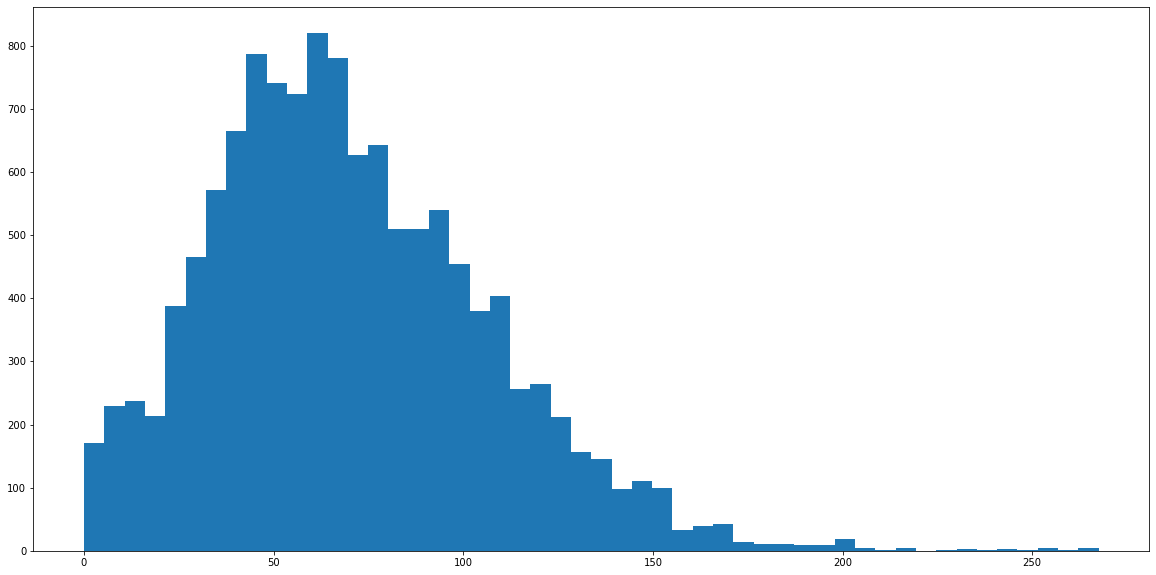

In [57]:
# let's look at the 30-day distribution; I believe it looked normal in the histograms that were plotted above
_ = plt.hist(win['SNOW30'], bins=50)

In [58]:
#This is kind of normal, but may have to smooth it out with a log function; let's test if it's normal
z, p = normaltest(win['SNOW30'], nan_policy='omit')
z

1055.2142570309584

That is based on the null hypothesis that the distribution is normal, so I guess it's not normal. It looks exponential; let's try the yeo johnson transform on it.

In [59]:
from scipy.stats import yeojohnson as yj


C:\Users\sjrek\anaconda3\lib\site-packages\scipy\stats\morestats.py:1371: RuntimeWarning: invalid value encountered in greater_equal
  pos = x >= 0  # binary mask
C:\Users\sjrek\anaconda3\lib\site-packages\scipy\stats\morestats.py:1479: RuntimeWarning: invalid value encountered in sign
  loglike += (lmb - 1) * (np.sign(data) * np.log(np.abs(data) + 1)).sum(axis=0)


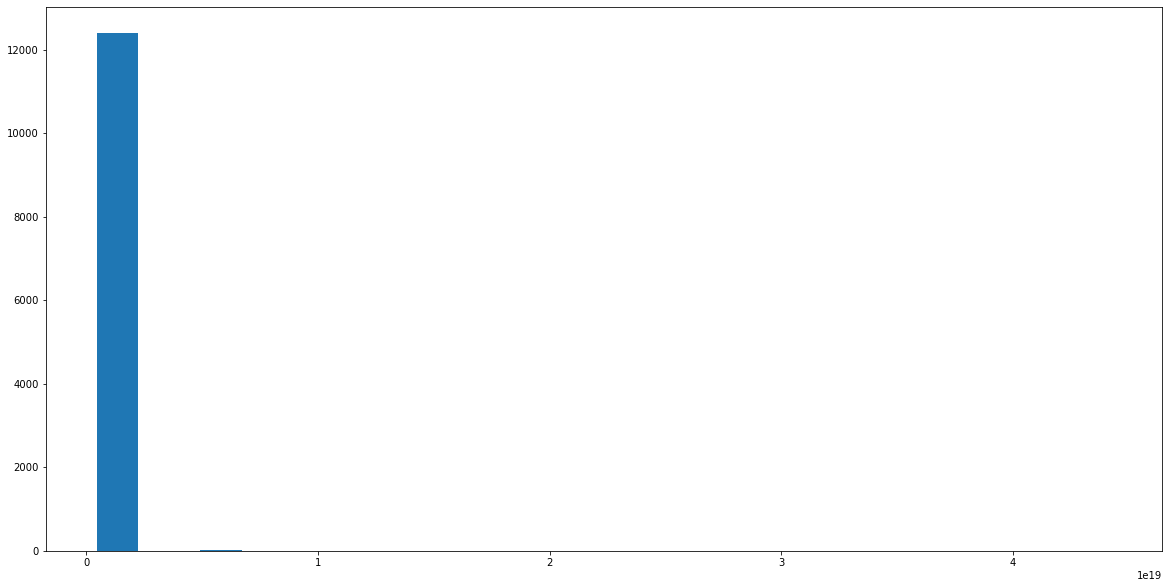

In [60]:
_ = plt.hist(yj(win['SNOW30']), bins=10)

That doesn't look good. What about taking the log of the 30-day snowfall.

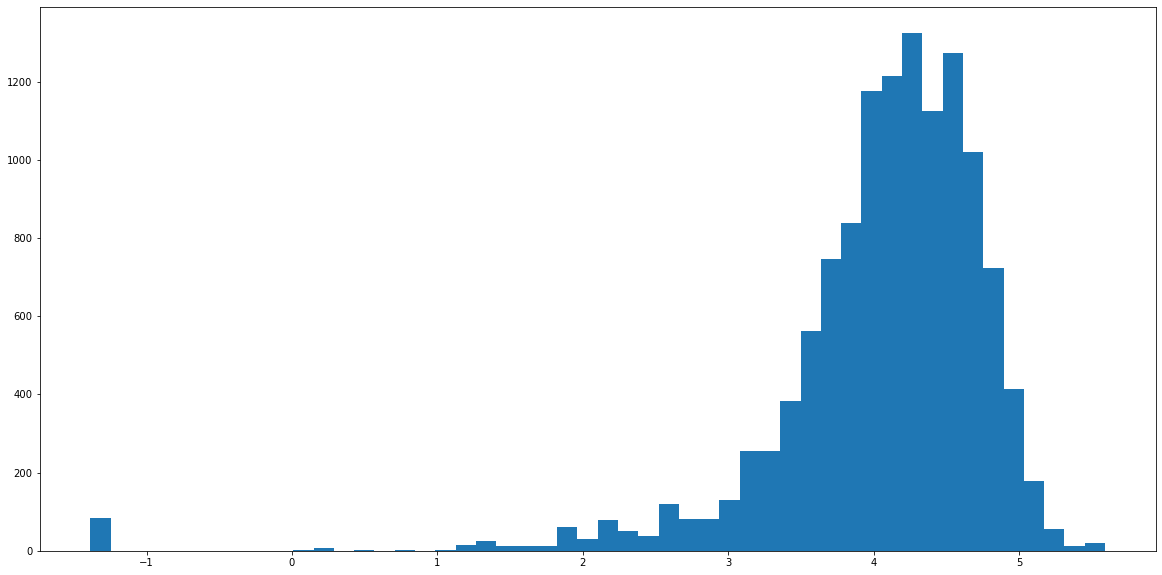

In [61]:
# taking the log of the 30 day snowfall plus an offset so that it doesn't hit infinity
snow30_log = np.log(win['SNOW30']+ 0.25)
_ = plt.hist(snow30_log, bins=50)

Let's remove the outliers and test that one as a normal distribution.

In [62]:
snow30_l = snow30_log[snow30_log > 2.5]
snow30_l

29       3.267666
30       3.504055
31       3.533687
32       3.834061
33       3.695110
           ...   
21788    3.636270
21789    3.382694
21790    3.319626
21791    3.305054
21792    3.305054
Name: SNOW30, Length: 12013, dtype: float64

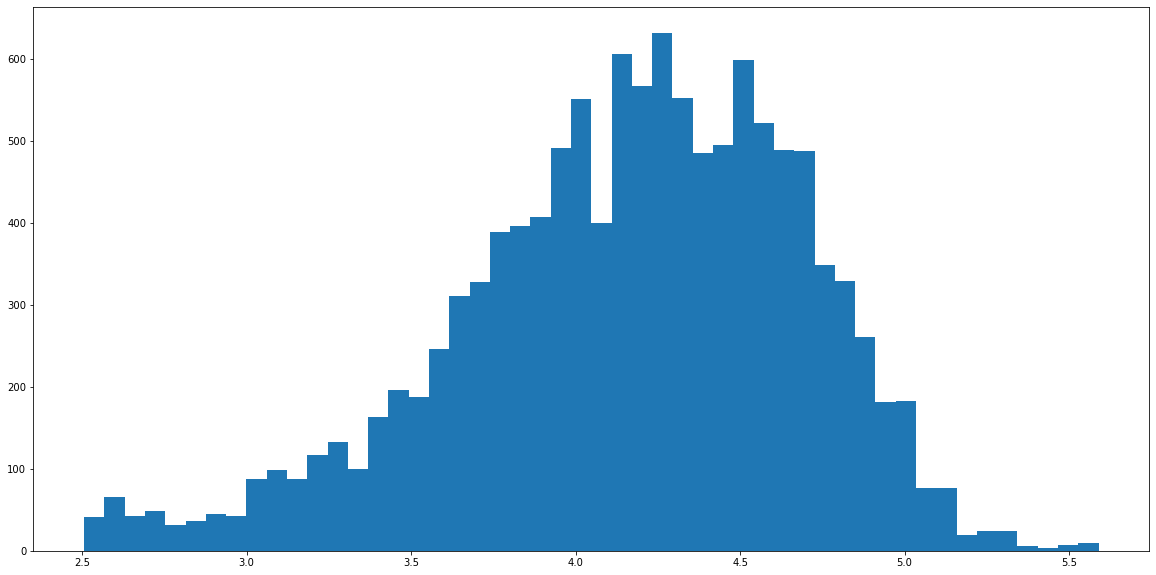

In [63]:
_ = plt.hist(snow30_l, bins=50)

That looks much better. Let's test that for normalacy

In [64]:
z, p = normaltest(snow30_l, nan_policy='omit')
print(z, p)

580.2900457190445 9.808839321454152e-127


I guess that's not a normal distribution either.

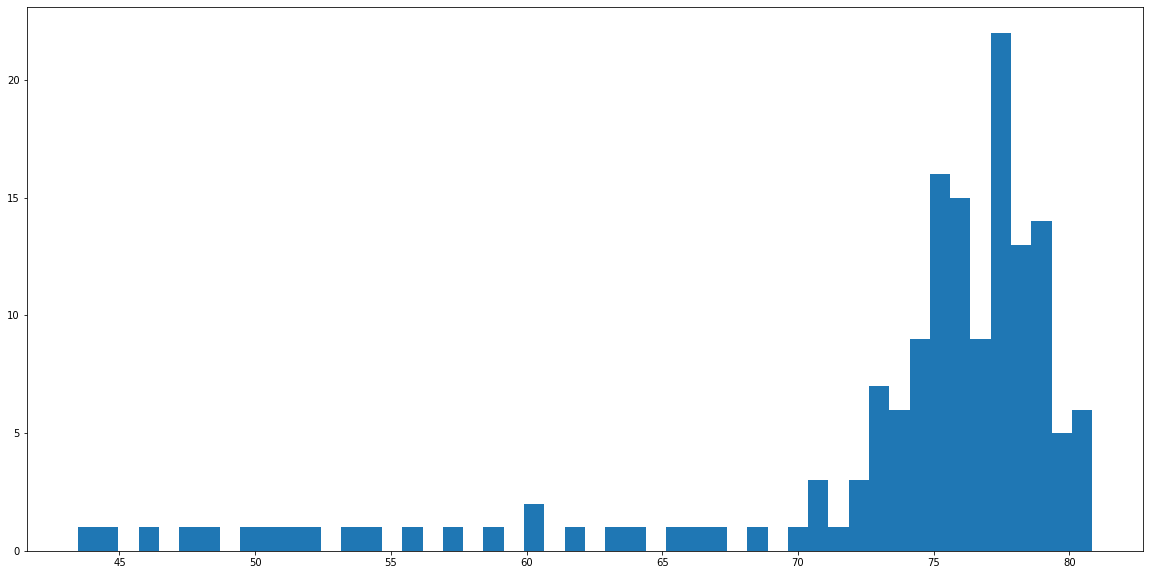

In [65]:
# this is the rolling 30-day average
_ = plt.hist(win_mda_top['SNOW30'], bins=50)

If we drop the low outliers, this might be closer to a normal distribution

In [66]:
snow30_avg = win_mda_top[win_mda_top['SNOW30'] > 70]
snow30_avg.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PDO,AMO,SNOW7,SNOW14,SNOW30
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.215877,2.530021,73.106165,32.892690,15.641047,23.732501,-0.073629,-0.013930,17.907951,35.989567,76.427224
std,0.050026,0.539591,17.089912,3.428496,3.209251,4.068828,0.123651,0.008597,1.597726,2.107816,2.356484
min,0.077778,1.139683,36.057971,28.643836,10.841610,18.378788,-0.216382,-0.031986,12.141270,30.934921,70.191176
25%,0.181152,2.161644,59.633562,30.654472,13.599679,21.075670,-0.177045,-0.021914,16.854710,34.220652,75.084261
50%,0.213827,2.454741,79.421860,31.503520,14.524466,22.167081,-0.143571,-0.012988,17.877536,35.877888,76.602899
75%,0.244674,2.895802,87.632143,34.882754,17.543421,26.599694,0.053164,-0.007351,19.149822,37.466957,78.240246
max,0.355588,3.953425,95.777778,43.650538,23.983333,34.743197,0.180164,0.003775,21.453425,40.861290,80.839726


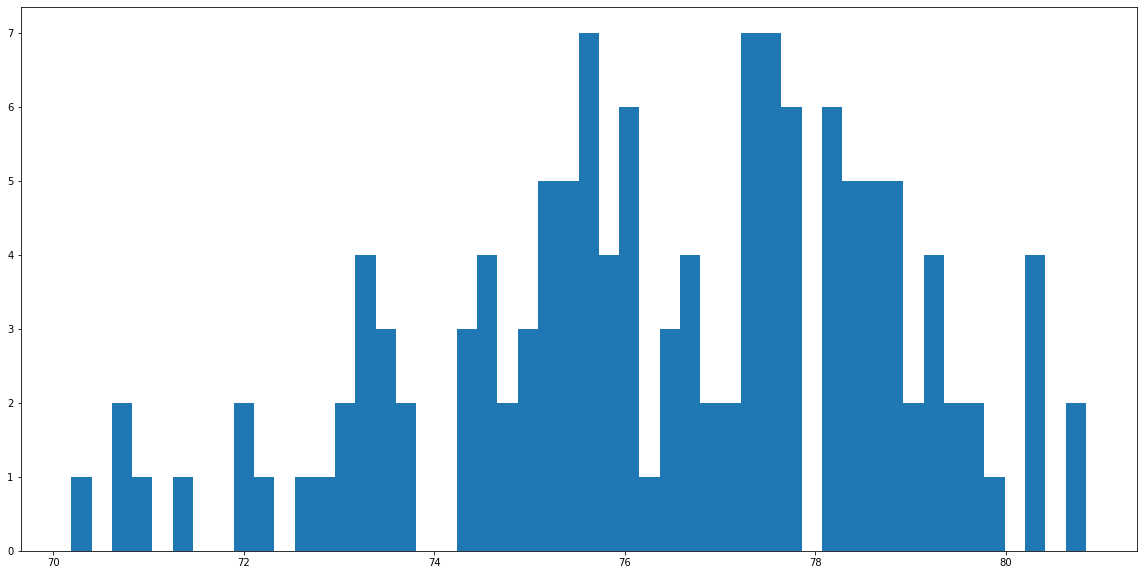

In [67]:
_ = plt.hist(snow30_avg['SNOW30'], bins=50)

In [68]:
#let's test it to see if it's normal.
z, p = normaltest(snow30_avg['SNOW30'], nan_policy='omit')
print(z, p)

4.795169546115504 0.0909373225409684


That's a lot better than previous results, but it's still not normal. I might as well try it for 7-day and 14-day totals.

C:\Users\sjrek\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\sjrek\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


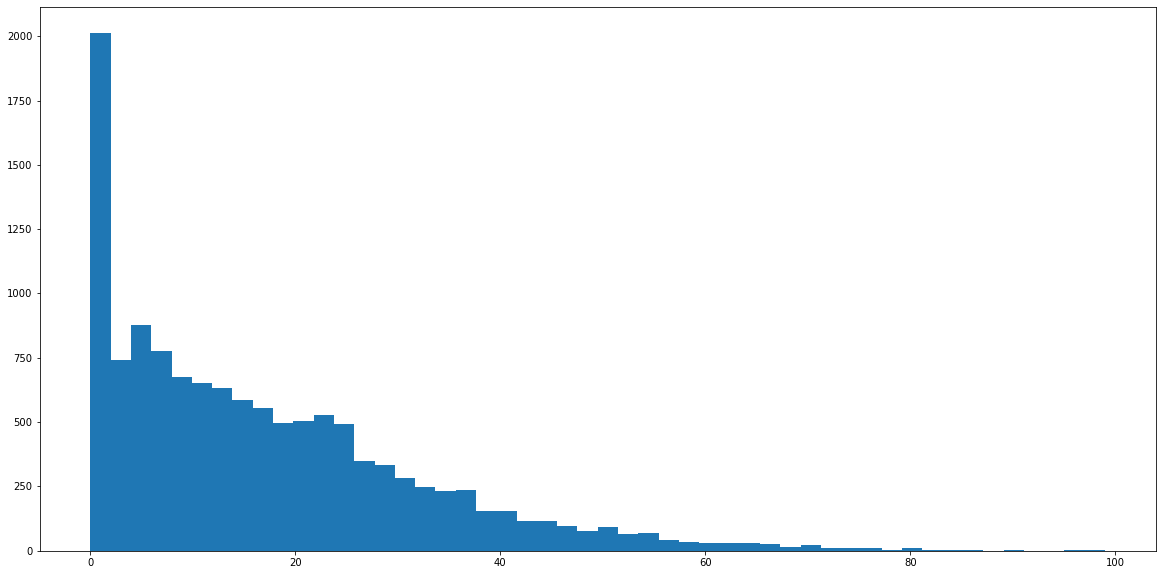

In [69]:
_ = plt.hist(win['SNOW7'], bins=50)

In [70]:
z, p = normaltest(win['SNOW7'], nan_policy='omit')
print(z,p)

2457.522038152259 0.0


That's not normal

In [71]:
snow7_log = np.log(win['SNOW7'] + 0.25)

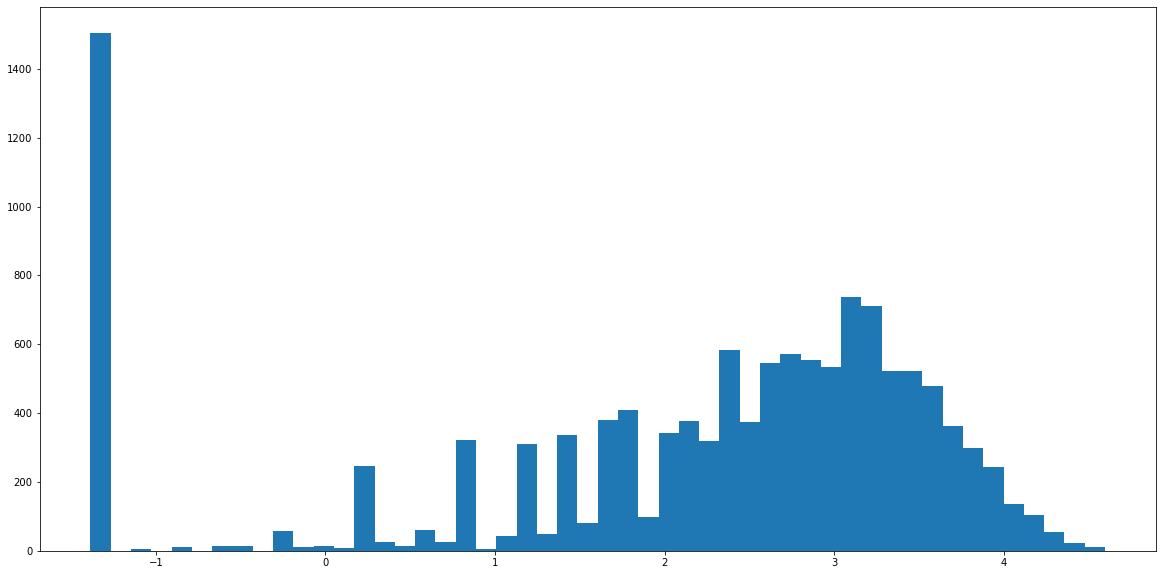

In [72]:
_ = plt.hist(snow7_log, bins=50)

In [73]:
# let's drop some of the outliers and see if it turns out normal
snow7_l = snow7_log[snow7_log > 1.9]

In [74]:
z, p = normaltest(snow7_l, nan_policy='omit')
print(z,p)

488.9004911931852 6.864473574573118e-107


That's still not normal. <br>
We are going to try it for 14-day as well and hope for the best.

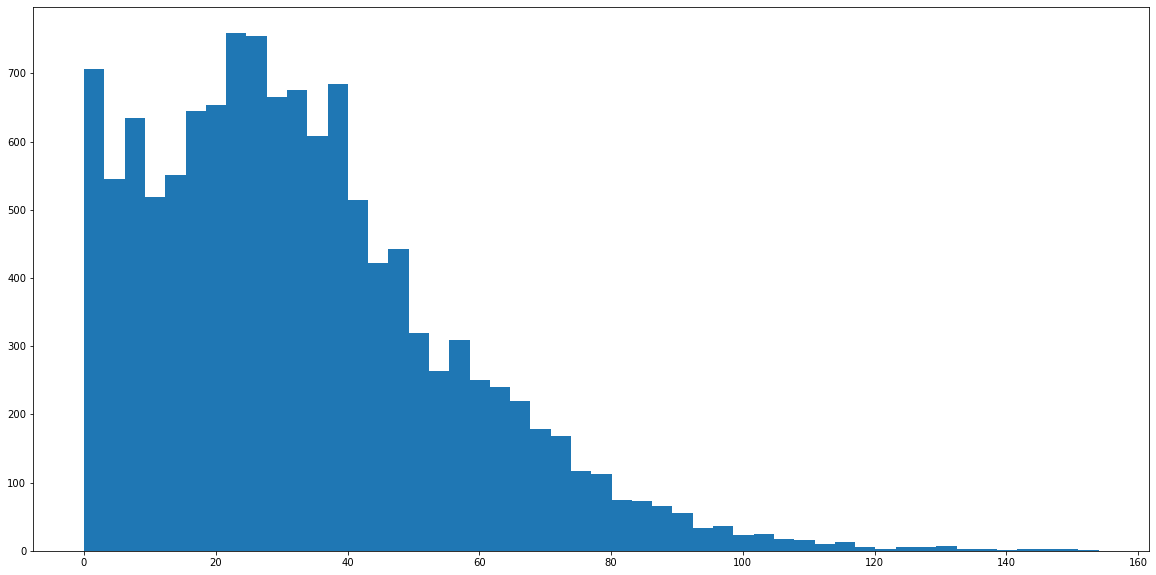

In [75]:
_ = plt.hist(win['SNOW14'], bins=50)

In [76]:
z, p = normaltest(win['SNOW14'], nan_policy='omit')
print(z,p)

1576.685325699257 0.0


That's also not normal. <br>
Let's see if it's any different for the log

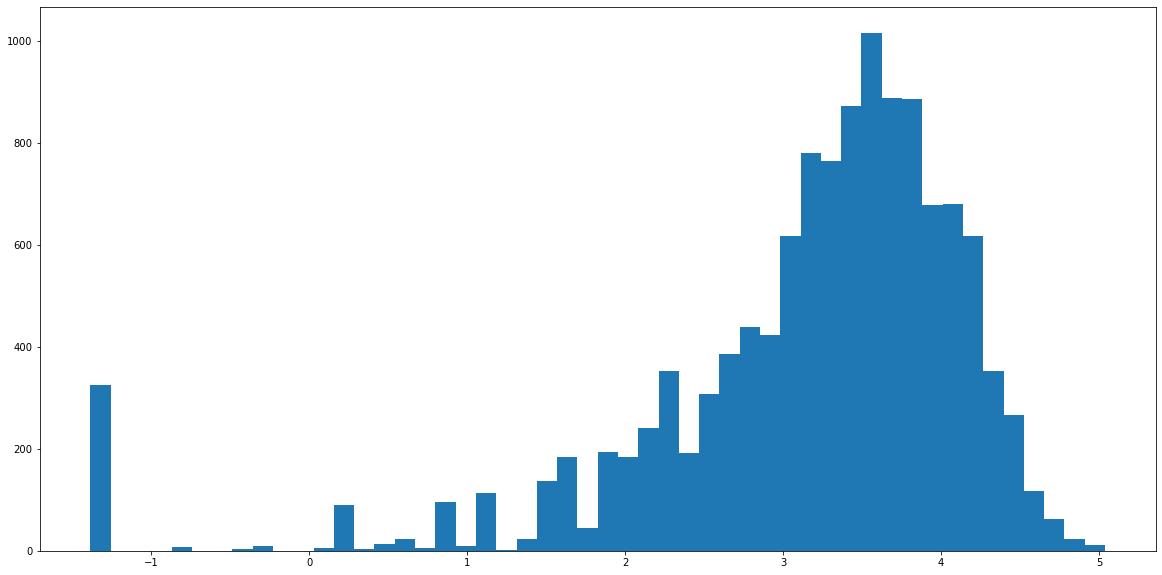

In [77]:
# let's try it for the log
snow14_log = np.log(win['SNOW14'] + 0.25)
_ = plt.hist(snow14_log, bins=50)

That is honestly the most promising plot that I have seen so far if we drop the outliers below 1.8

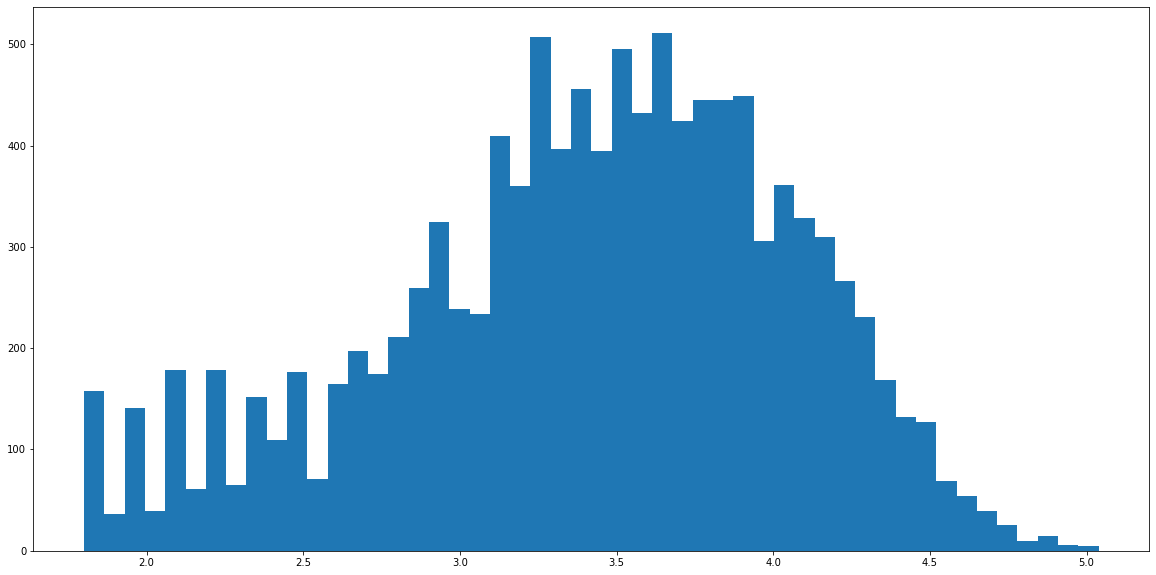

In [78]:
snow14_l = snow14_log[snow14_log > 1.8]
_ = plt.hist(snow14_l, bins=50)

There are some spikes that we also may have to eliminate from the left tail, but it looks pretty good.

In [79]:
z, p = normaltest(snow14_l, nan_policy='omit')
print(z,p)

383.2718303224766 5.937170364498967e-84


Let's see if we remove more of the spikes below 2.6 if this comes out normal.

In [80]:
snow14_l = snow14_log[snow14_log > 2.6]
z, p = normaltest(snow14_l, nan_policy='omit')
print(z,p)

445.4689542680498 1.8520199094284297e-97


That's not normal either. Is anything normal about snowfall?

In [81]:
# annual snowfall win_y
z, p = normaltest(win_y['SNOW'], nan_policy='omit')
print(z, p)

5.208817976535119 0.07394682772824022


That looks a lot more normal than the others, but it's still not normally distributed.

In [82]:
# that looks more normal than the others. Based on the Central Limit Theorem, could we test the average
z, p = normaltest(win_mda_top['SNOW7'], nan_policy='omit') 
print(z, p)

2.562319896557703 0.27771497853959115


That looks much better, but still not normal.

So, the dependent variable that we are interested in does not appear to be normally distributed. However, we will also look at the other variable of interest: AMO, PDO, and TOBS.

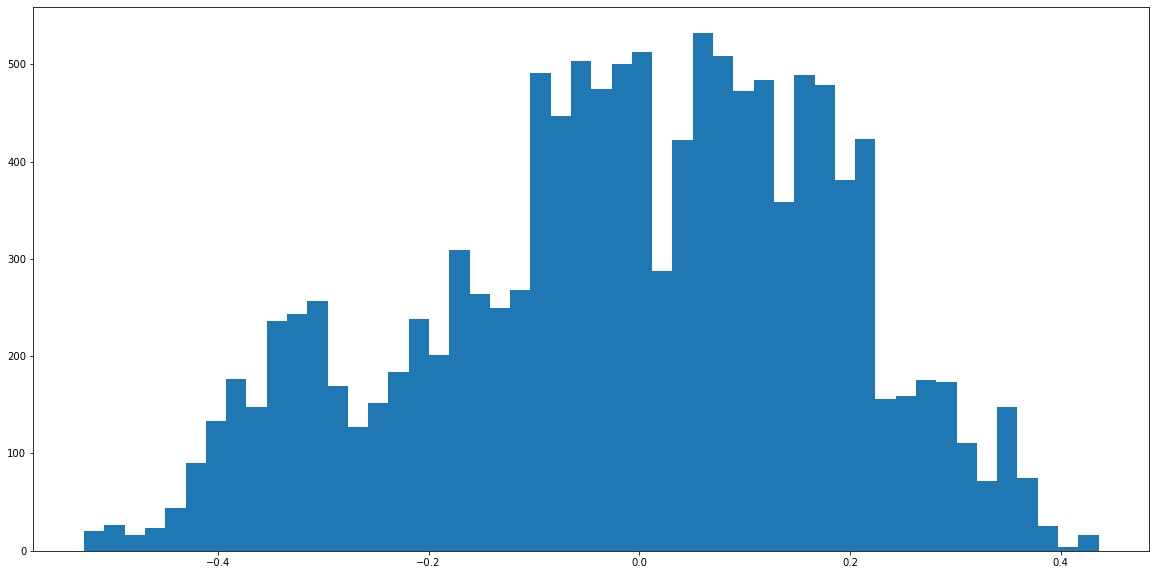

In [83]:
# distribution of AMO first
_ = plt.hist(win['AMO'], bins=50)

In [84]:
#This is kind of normal, but may have to smooth it out with a log function; let's test if it's normal
z, p = normaltest(win['AMO'], nan_policy='omit')
print(z, p)

515.4328996137224 1.188961941626663e-112


Since the null hypthosesis is normal, we need to reject this as normally distributed.

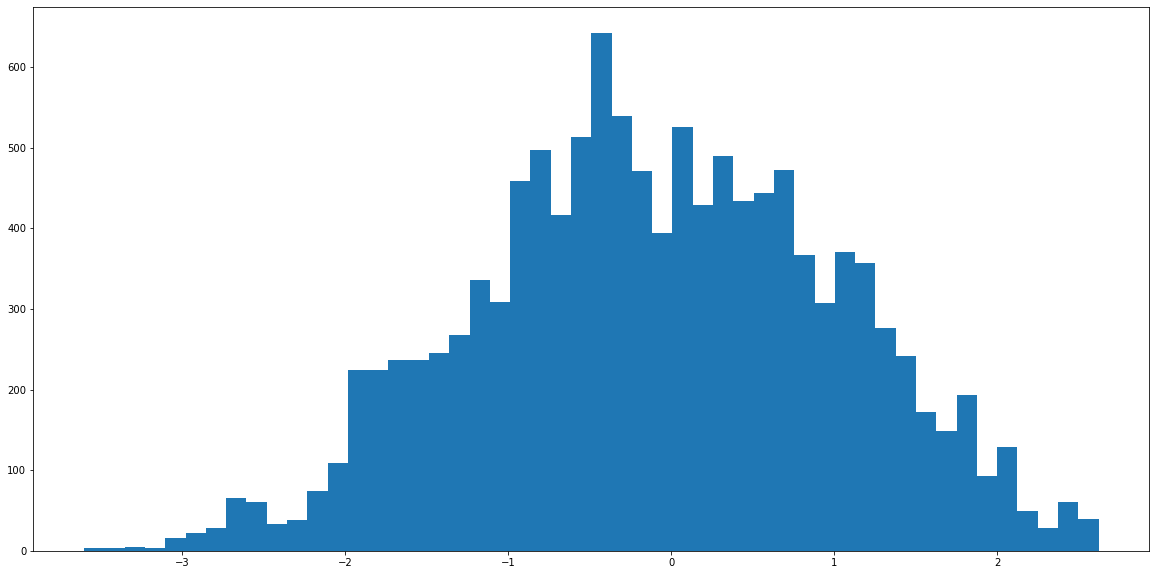

In [85]:
# distribution of PDO second
_ = plt.hist(win['PDO'], bins=50)

That looks kind of normal.

In [86]:
#This is kind of normal, but may have to smooth it out with a log function; let's test if it's normal
z, p = normaltest(win['PDO'], nan_policy='omit')
print(z, p)

151.39847876873156 1.3311838837289557e-33


It's not normal.

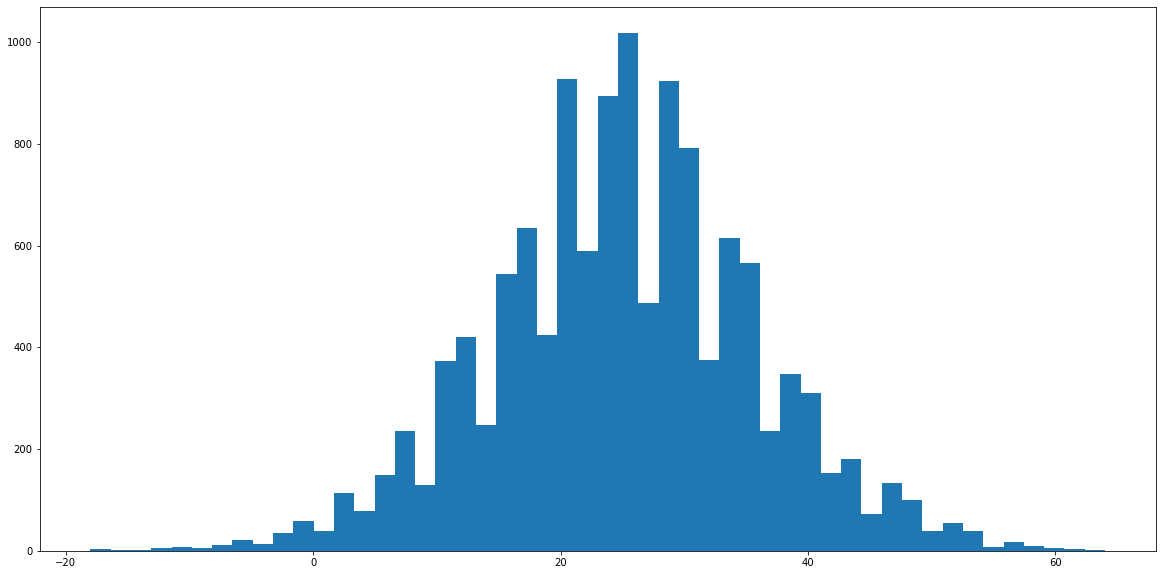

In [87]:
# distribution of TOBS lastly
_ = plt.hist(win['TOBS'], bins=50)

Those are some interesting peaks and valley, but that could just be cause by the bins.

In [88]:
#This is kind of normal, but may have to smooth it out with a log function; let's test if it's normal
z, p = normaltest(win['TOBS'], nan_policy='omit')
print(z, p)

32.93585158064398 7.048077986526782e-08


That's not normal either. <br>
I should also look at precipitation as well. 

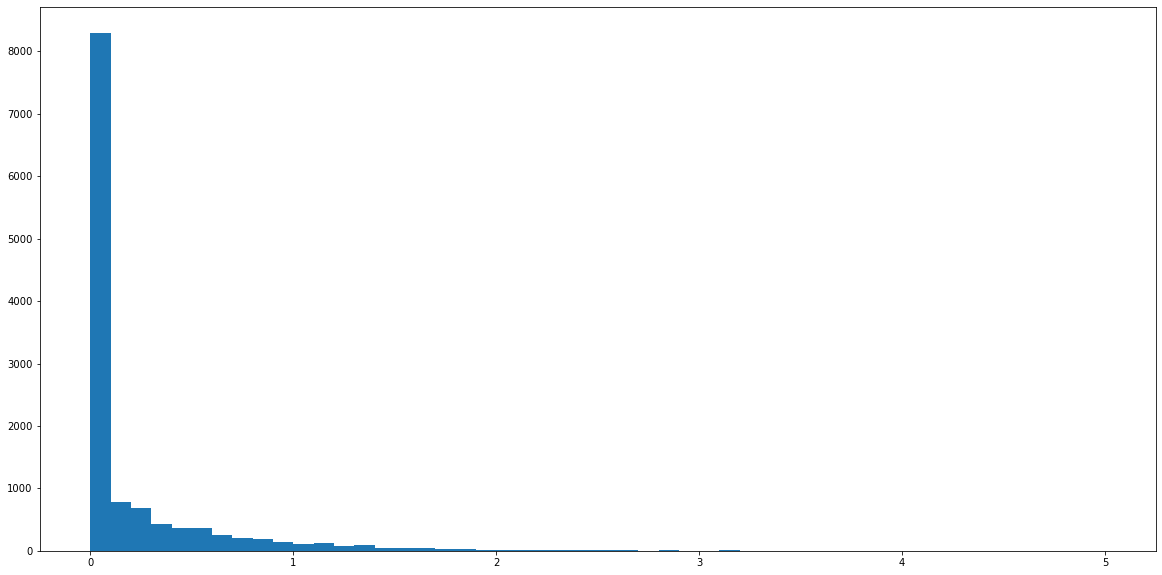

In [89]:
# distribution of TOBS lastly
_ = plt.hist(win['PRCP'], bins=50)

That doesn't look normal either. That concludes looking that the distributions, but let's step back to that chance of getting a certain amount of snowfall. What might be better is to establish what percentage of years does a certain date get more snow than another date. Let's see the most drastic difference that we can find in the heart of the season.

Let's take a look back 

In [90]:
# let's find those min and max values for 10-in snowfall
print(win_mdc7_top.loc['01-01':'02-28',:]['PERC'].min(), win_mdc7_top.loc['01-01':'02-28',:]['PERC'].idxmin())

47.94520547945205 02-06


In [91]:
print(win_mdc7_top.loc['01-01':'02-28',:]['PERC'].max(), win_mdc7_top.loc['01-01':'02-28',:]['PERC'].idxmax())

75.34246575342466 02-20


Looks like the minimum values is on 02-06 of 47.945205%; maximum is on 02-20 of 75.342466%

In [92]:
win['YEAR'] = win.DATE.dt.year

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
win_220 = win[win['MD'] == '02-20']
win_206 = win[win['MD'] == '02-06']
print(len(win_220), len(win_206))

73 73


In [94]:
#win_220.set_index('YEAR')
win_220 = win_220.reset_index(drop=True)

In [95]:
win_206 = win_206.reset_index(drop=True)

In [96]:
# let's see how often the week beginning February 20th got more snow than the week beginning February 6th
better = (win_220['SNOW7'] >= win_206['SNOW7']) #['SNOW7']
(better.sum()/len(win_220))*100

57.534246575342465

Snowfall for the week of February 20th was bettter than snowfall for the week of February 6th in *57.53%* of the years. I was hoping for a more dramatic result than that.

## Time Series Analysis
Since the snowfall occurs over time, I should look at that snowfall data as it varies over time - to try to break it down.

In [131]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

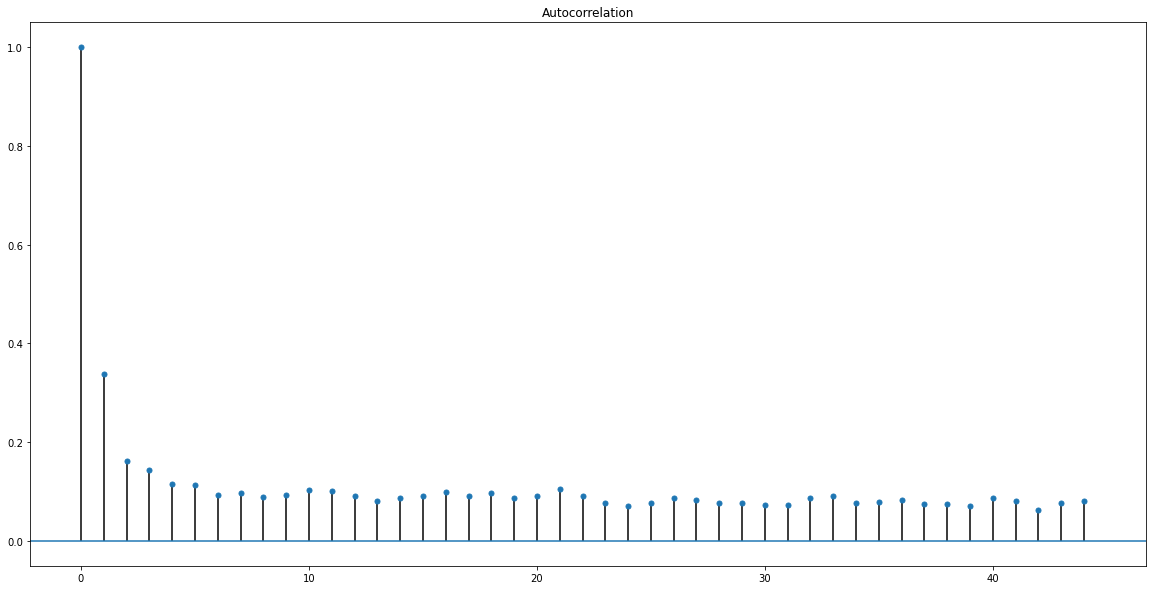

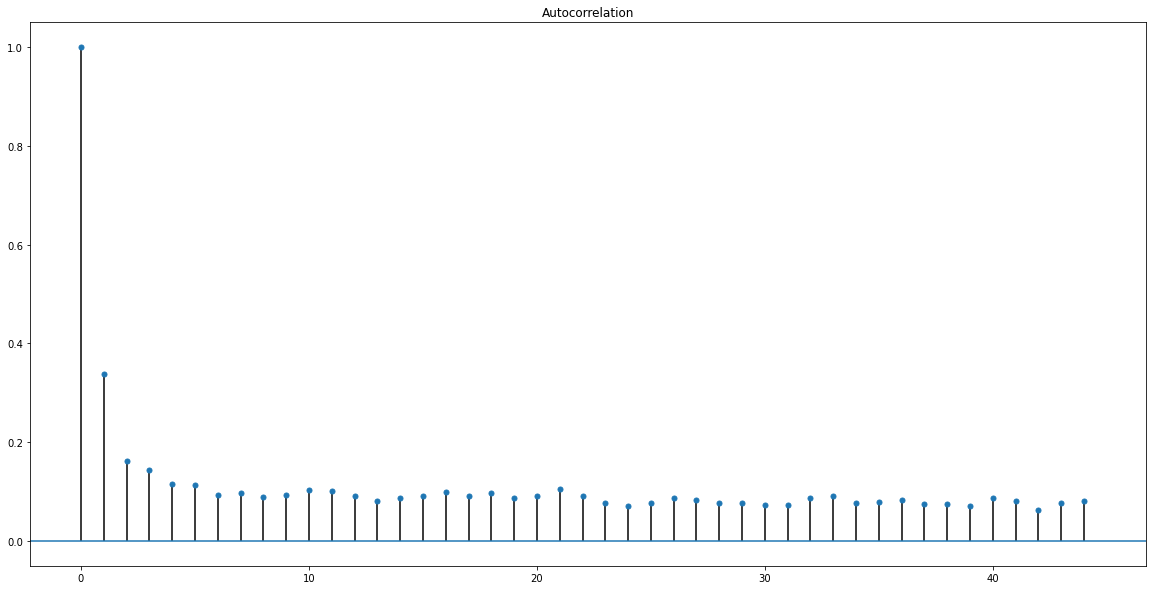

In [132]:
# looking at the standard ACF Plot
plot_acf(ALTA['SNOW'], alpha=1)

I think that covers our EDA for now.